In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gprofiler import GProfiler

# Configure scanpy settings
sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Pathway Enrichment Analysis: M(Kp) Signature Validation

## Overview

This notebook performs functional pathway enrichment analysis to validate and characterize the M(Kp) signature - a novel macrophage polarization state induced by direct contact with Klebsiella pneumoniae. The analysis focuses on identifying STAT6 pathway activation and other functional signatures that distinguish bacterial-contacted cells from bystander cells.

## Analysis Strategy

### Key Validation Targets:

1. **STAT6 Pathway Activation**: The central hypothesis - M(Kp) cells should show STAT6 transcription factor activity
2. **Alternative Activation Signatures**: IL-4/IL-13 response pathways associated with M(Kp) polarization  
3. **Capsule Recognition Programs**: Genes involved in polysaccharide recognition and processing
4. **Novel Antimicrobial Responses**: Distinct from classical inflammatory responses

### Pathway Analysis Workflow:

1. **Validation Controls**: Confirm classical infection responses in overall comparisons
2. **M(Kp) Signature Discovery**: Focus on bacterial contact vs bystander comparisons
3. **Cell Type Specificity**: Compare AM vs IM responses to bacterial contact
4. **Cluster-Level Analysis**: Examine if STAT6 signals are concentrated in specific clusters

## Expected Findings

The original study identified M(Kp) as primarily an IM (interstitial macrophage) phenomenon, with STAT6 pathway enrichment being the key mechanistic finding that distinguishes this novel polarization state from classical antimicrobial responses.

## Setup and Data Loading

### Initialize G:Profiler for Pathway Analysis

In [2]:
# Initialize G:Profiler for mouse pathway analysis
gp = GProfiler(return_dataframe=True)
organism_id = 'mmusculus'

print(f"G:Profiler configured for {organism_id}")
print("Available pathway databases: GO:BP, GO:MF, KEGG, REAC, WP, TF, HP")

G:Profiler configured for mmusculus
Available pathway databases: GO:BP, GO:MF, KEGG, REAC, WP, TF, HP


### Load Differential Expression Results

In [3]:
# Load datasets with computed differential expression results
adata = sc.read_h5ad('condition_DE_analysis.h5ad')          # Overall infection analysis
am_cells = sc.read_h5ad('am_cells_DE.h5ad')                 # AM-specific analysis
im_cells = sc.read_h5ad('im_cells_DE.h5ad')                 # IM-specific analysis
infected_cells = sc.read_h5ad('infected_cells_DE.h5ad')     # Bacterial contact analysis

print("Loaded datasets:")
print(f"  Overall dataset: {adata.n_obs:,} cells")
print(f"  AM subset: {am_cells.n_obs:,} cells") 
print(f"  IM subset: {im_cells.n_obs:,} cells")
print(f"  Infected tissue: {infected_cells.n_obs:,} cells")

# Verify differential expression keys are available
available_keys = [k for k in infected_cells.uns.keys() if 'rank' in k or 'vs' in k]
print(f"\nAvailable DE analysis keys: {available_keys}")

Loaded datasets:
  Overall dataset: 2,399 cells
  AM subset: 1,151 cells
  IM subset: 1,248 cells
  Infected tissue: 1,608 cells

Available DE analysis keys: ['am_bacterial_vs_bystander', 'bacterial_vs_bystander', 'im_bacterial_vs_bystander', 'ranked_genes']


## Analysis Functions and Search Terms

### Helper Functions for Pathway Analysis

In [4]:
# Helper functions for extracting genes and searching pathways
def get_top_genes(adata_obj, key, group, n_genes=20):
    """Extract top differentially expressed genes from scanpy results"""
    if key in adata_obj.uns:
        genes = adata_obj.uns[key]['names'][group][:n_genes].tolist()
        return [g for g in genes if pd.notna(g)]
    else:
        print(f"Key {key} not found")
        return []

def search_pathways(df, search_terms):
    """Search pathway results for specific terms of interest"""
    if df.empty:
        return pd.DataFrame()
    mask = df['name'].str.contains('|'.join(search_terms), case=False, na=False)
    return df[mask][['name', 'p_value', 'source', 'intersection_size']]

# Define search terms for key pathway categories
stat6_terms = ['STAT6', 'DNA-binding transcription factor activity', 'IL-4', 'IL-13', 'Th2', 'alternative activation']
immune_terms = ['immune', 'antimicrobial', 'bacterial', 'pathogen', 'defense']
interferon_terms = ['interferon', 'antiviral', 'IFN']

print("Pathway analysis functions initialized")
print("Search term categories: STAT6/M2, Immune/antimicrobial, Interferon/antiviral")

Pathway analysis functions initialized
Search term categories: STAT6/M2, Immune/antimicrobial, Interferon/antiviral


## Validation Analysis: Classical Infection Responses

### 1. Overall Infection Response Pathways

**Purpose**: Validate that our model shows expected classical infection responses before searching for novel M(Kp) signatures.

**Expected**: General immune activation, antimicrobial responses, interferon pathways - typical macrophage responses to bacterial infection.

In [6]:
# Extract top genes from overall infection response
overall_infection_genes = get_top_genes(adata, 'infected_vs_control', 'Infected', 20)
print(f"Overall infection genes (n={len(overall_infection_genes)}): {overall_infection_genes}")

# Perform pathway enrichment analysis
print("=== Analyzing Overall Infection Response Pathways ===")
overall_infection_pathways = gp.profile(
    organism=organism_id,
    query=overall_infection_genes,
    sources=['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP', 'TF'],
    user_threshold=0.05
)

# Search for key pathway categories
print("STAT6-related pathways in overall infection:")
stat6_results = search_pathways(overall_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")

print("\nImmune/antimicrobial pathways in overall infection:")
immune_results = search_pathways(overall_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      

print("\nInterferon pathways in overall infection:")
ifn_results = search_pathways(overall_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

Overall infection genes (n=20): ['Gbp2', 'Gbp7', 'Stat1', 'Nampt', 'Wfdc17', 'Gbp5', 'Parp14', 'Ctsc', 'AW112010', 'Ms4a6d', 'Lilrb4a', 'Ifih1', 'Cfb', 'Ifi47', 'AY036118', 'Rnf213', 'Tgfbi', 'Fbxl5', 'Oasl2', 'Slfn2']
=== Analyzing Overall Infection Response Pathways ===
STAT6-related pathways in overall infection:
0 found: None found

Immune/antimicrobial pathways in overall infection:
15 found:                            name       p_value source  intersection_size
0              defense response  6.009491e-09  GO:BP                 12
1        innate immune response  1.604638e-08  GO:BP                 10
2               immune response  1.842729e-08  GO:BP                 12
3  defense response to symbiont  3.362385e-08  GO:BP                 10
4         immune system process  3.726257e-08  GO:BP                 13

Interferon pathways in overall infection:
7 found:                                        name   p_value source  \
12  cellular response to type II interferon  0.0000

### 2. Alveolar Macrophage Infection Response

**Focus**: AM-specific responses to infection environment.

**Expected**: Phagocytosis, tissue homeostasis disruption, airway-specific immune responses.

In [7]:
# Extract and analyze AM-specific infection response
am_overall_infection_genes = get_top_genes(am_cells, 'am_infected_vs_control', 'Infected', 20)
print(f"AM infection genes (n={len(am_overall_infection_genes)}): {am_overall_infection_genes}")

print("=== Analyzing AM-Specific Infection Response ===")
am_overall_infection_pathways = gp.profile(
    organism=organism_id,
    query=am_overall_infection_genes,
    sources=['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP', 'TF'],
    user_threshold=0.05
)

print("STAT6-related pathways in AM infection:")
stat6_results = search_pathways(am_overall_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")

print("\nImmune/antimicrobial pathways in AM infection:")
immune_results = search_pathways(am_overall_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      

print("\nInterferon pathways in AM infection:")
ifn_results = search_pathways(am_overall_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

AM infection genes (n=20): ['mt-Nd4l', 'Plek', 'AY036118', 'Macf1', 'Ptprc', 'Wfdc17', 'Fbxl5', 'Gm21092', 'mt-Nd6', 'March1', 'Vps13c', 'mt-Nd5', 'Ifih1', 'Gm10076', 'Parp14', 'Usp9x', 'AI607873', 'Gbp2', 'Irf1', 'Ifi204']
=== Analyzing AM-Specific Infection Response ===
STAT6-related pathways in AM infection:
0 found: None found

Immune/antimicrobial pathways in AM infection:
9 found:                                     name   p_value source  intersection_size
9     defense response to other organism  0.003488  GO:BP                  7
10  regulation of innate immune response  0.003913  GO:BP                  5
18         regulation of immune response  0.010117  GO:BP                  6
22         activation of immune response  0.012051  GO:BP                  5
23                innate immune response  0.012819  GO:BP                  6

Interferon pathways in AM infection:
4 found:                                        name   p_value source  \
11     cellular response to interfero

### 3. Interstitial Macrophage Infection Response

**Focus**: IM-specific responses to infection environment.

**Expected**: Enhanced interferon responses, tissue surveillance, stronger antiviral programs (Stat1, Gbp genes).

In [ ]:
# Extract and analyze IM-specific infection response
im_overall_infection_genes = get_top_genes(im_cells, 'im_infected_vs_control', 'Infected', 20)
print(f"IM infection genes (n={len(im_overall_infection_genes)}): {im_overall_infection_genes}")

print("=== Analyzing IM-Specific Infection Response ===")
im_overall_infection_pathways = gp.profile(
    organism=organism_id,
    query=im_overall_infection_genes,
    sources=['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP', 'TF', 'HP'],
    user_threshold=0.05
)

print("STAT6-related pathways in IM infection:")
stat6_results = search_pathways(im_overall_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")

print("\nImmune/antimicrobial pathways in IM infection:")
immune_results = search_pathways(im_overall_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      

print("\nInterferon pathways in IM infection:")
ifn_results = search_pathways(im_overall_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

## M(Kp) Signature Analysis: Bacterial Contact Responses

### 4. Overall Bacterial Contact vs Bystander Cells (Critical Analysis)

**Purpose**: Identify the M(Kp) signature - genes specifically induced by direct bacterial contact.

**Critical Importance**: This is the key comparison for discovering the novel macrophage polarization state.

**Expected M(Kp) Signatures**:
- STAT6 pathway activation
- Capsule polysaccharide recognition  
- Novel antimicrobial programs distinct from general inflammation
- IL-4/IL-13 response pathways

In [9]:
# Extract genes from bacterial contact vs bystander comparison  
infection_genes = get_top_genes(infected_cells, 'bacterial_vs_bystander', 'KP+', 20)
print(f"Bacterial contact signature genes (n={len(infection_genes)}): {infection_genes}")

print("=== Analyzing M(Kp) Signature Pathways ===")
infection_pathways = gp.profile(
    organism=organism_id,
    query=infection_genes,
    sources=['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP', 'TF', 'HP'],
    user_threshold=0.05
)

print("STAT6-related pathways in bacterial contact:")
stat6_results = search_pathways(infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")

print("\nImmune/antimicrobial pathways in bacterial contact:")
immune_results = search_pathways(infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      

print("\nInterferon pathways in bacterial contact:")
ifn_results = search_pathways(infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

Bacterial contact signature genes (n=20): ['Fth1', 'Gm10076', 'Lgals3', 'Cxcl2', 'Cxcl3', 'Txn1', 'Cstb', 'Capg', 'AA467197', 'Ftl1', 'Il1a', 'Fabp5', 'S100a9', 'Prdx1', 'Slpi', 'S100a8', 'Atp6v1g1', 'Cd63', 'Gabarap', 'Il1rn']
=== Analyzing M(Kp) Signature Pathways ===
STAT6-related pathways in bacterial contact:
0 found: None found

Immune/antimicrobial pathways in bacterial contact:
10 found:                                         name   p_value source  \
12  response to molecule of bacterial origin  0.000424  GO:BP   
18                           immune response  0.001625  GO:BP   
19                      Innate Immune System  0.001715   REAC   
20                             Immune System  0.001758   REAC   
26            antimicrobial humoral response  0.002861  GO:BP   

    intersection_size  
12                  6  
18                  9  
19                  9  
20                 11  
26                  4  

Interferon pathways in bacterial contact:
0 found: None found


### 5. AM-Specific Bacterial Contact Analysis

**Focus**: How alveolar macrophages respond to direct bacterial contact.

**Expected**: AM-specific components of the M(Kp) signature.

In [12]:
# Extract and analyze AM bacterial contact response
am_infection_genes = get_top_genes(infected_cells, 'am_bacterial_vs_bystander', 'KP+', 20)
print(f"AM bacterial contact genes (n={len(am_infection_genes)}): {am_infection_genes}")

print("=== Analyzing AM Bacterial Contact Response ===")
am_infection_pathways = gp.profile(
    organism=organism_id,
    query=am_infection_genes,
    sources=['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP', 'TF', 'HP'],
    user_threshold=0.05
)

print("STAT6-related pathways in AM bacterial contact:")
stat6_results = search_pathways(am_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")

print("\nImmune/antimicrobial pathways in AM bacterial contact:")
immune_results = search_pathways(am_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      

print("\nInterferon pathways in AM bacterial contact:")
ifn_results = search_pathways(am_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")



AM bacterial contact genes (n=20): ['Gm10076', 'Fcer1g', 'Cd52', 'Il1b', 'Prdx5', 'Cd74', 'H2-Q7', 'H2-D1', 'Atox1', 'Samhd1', 'Psme2', 'AA467197', 'Srgn', 'H2-K1', 'Cxcl3', 'Bcl2a1d', 'Stat1', 'Psmb8', 'Cyba', 'Zbp1']
=== Analyzing AM Bacterial Contact Response ===
STAT6-related pathways in AM bacterial contact:
0 found: None found

Immune/antimicrobial pathways in AM bacterial contact:
27 found:                                               name       p_value source  \
1                    regulation of immune response  1.487989e-07  GO:BP   
6                                  immune response  6.383398e-07  GO:BP   
7           positive regulation of immune response  7.365146e-07  GO:BP   
8  positive regulation of adaptive immune response  1.135122e-06  GO:BP   
9              regulation of immune system process  1.296600e-06  GO:BP   

   intersection_size  
1                 10  
6                 12  
7                  9  
8                  6  
9                 11  

Interfero

### 6. IM-Specific Bacterial Contact Analysis

**Focus**: How interstitial macrophages respond to direct bacterial contact.

**Critical Importance**: The original study found M(Kp) primarily in IMs - this should show the strongest STAT6 signal.

In [14]:
# Extract and analyze IM bacterial contact response
im_infection_genes = get_top_genes(infected_cells, 'im_bacterial_vs_bystander', 'KP+', 20)
print(f"\nIM bacterial contact genes (n={len(im_infection_genes)}): {im_infection_genes}")

print("=== Analyzing IM Bacterial Contact Response ===")
im_infection_pathways = gp.profile(
    organism=organism_id,
    query=im_infection_genes,
    sources=['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP', 'TF', 'HP'],
    user_threshold=0.05
)

print("STAT6-related pathways in IM bacterial contact:")
stat6_results = search_pathways(im_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")

print("\nImmune/antimicrobial pathways in IM bacterial contact:")
immune_results = search_pathways(im_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      

print("\nInterferon pathways in IM bacterial contact:")
ifn_results = search_pathways(im_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")


IM bacterial contact genes (n=20): ['Ctsd', 'Chil3', 'Fth1', 'Cd9', 'Vim', 'Fabp5', 'Ftl1', 'Lgals3', 'Wfdc21', 'F7', 'Atp6v0d2', 'Prdx1', 'Actn1', 'Slpi', 'Txn1', 'Plet1', 'S100a10', 'Pld3', 'Cd44', 'Anxa2']
=== Analyzing IM Bacterial Contact Response ===
STAT6-related pathways in IM bacterial contact:
0 found: None found

Immune/antimicrobial pathways in IM bacterial contact:
2 found:                     name   p_value source  intersection_size
5  immune system process  0.013476  GO:BP                 10
8   Innate Immune System  0.018008   REAC                  8

Interferon pathways in IM bacterial contact:
0 found: None found


## Summary and Interpretation

### Current Findings Assessment

**STAT6 Pathway Detection**: No direct STAT6 pathway enrichment was found in any of the bacterial contact comparisons, which differs from the original study's key finding.

**Validated Classical Responses**: 
- Strong interferon responses in overall infection (especially IM)
- Robust antimicrobial and immune activation pathways
- Clear distinction between bacterial-contacted and bystander cells
- Cell type-specific infection responses

### Possible Explanations for Missing STAT6 Signal

1. **Temporal Dynamics**: M(Kp) may be a transient state not captured at this timepoint
2. **Signal Dilution**: STAT6-expressing cells may be a small subset within our current groupings
3. **Cluster-Specific Expression**: The signal might be concentrated in specific subclusters
4. **Model Differences**: Experimental conditions may differ from the original study

### Alternative Discoveries

The analysis reveals important biology even without the STAT6 signature:
- **Iron Sequestration**: Nutritional immunity responses (Fth1, Ftl1)
- **Neutrophil Recruitment**: Classical inflammatory responses (Cxcl2, Cxcl3)
- **Tissue Remodeling**: Extracellular matrix responses
- **Cell Type Specificity**: Clear AM vs IM functional differences

### Next Steps: Cluster-Level Analysis

To search for concentrated STAT6 signals, we examine clustering within infected tissue to identify potential M(Kp)-enriched subpopulations.

## Exploratory Cluster Analysis

### Infected Tissue Clustering

Examine if STAT6 signals might be concentrated in specific subclusters within the infected tissue, which could explain why the signal was not detected in the broader comparisons.

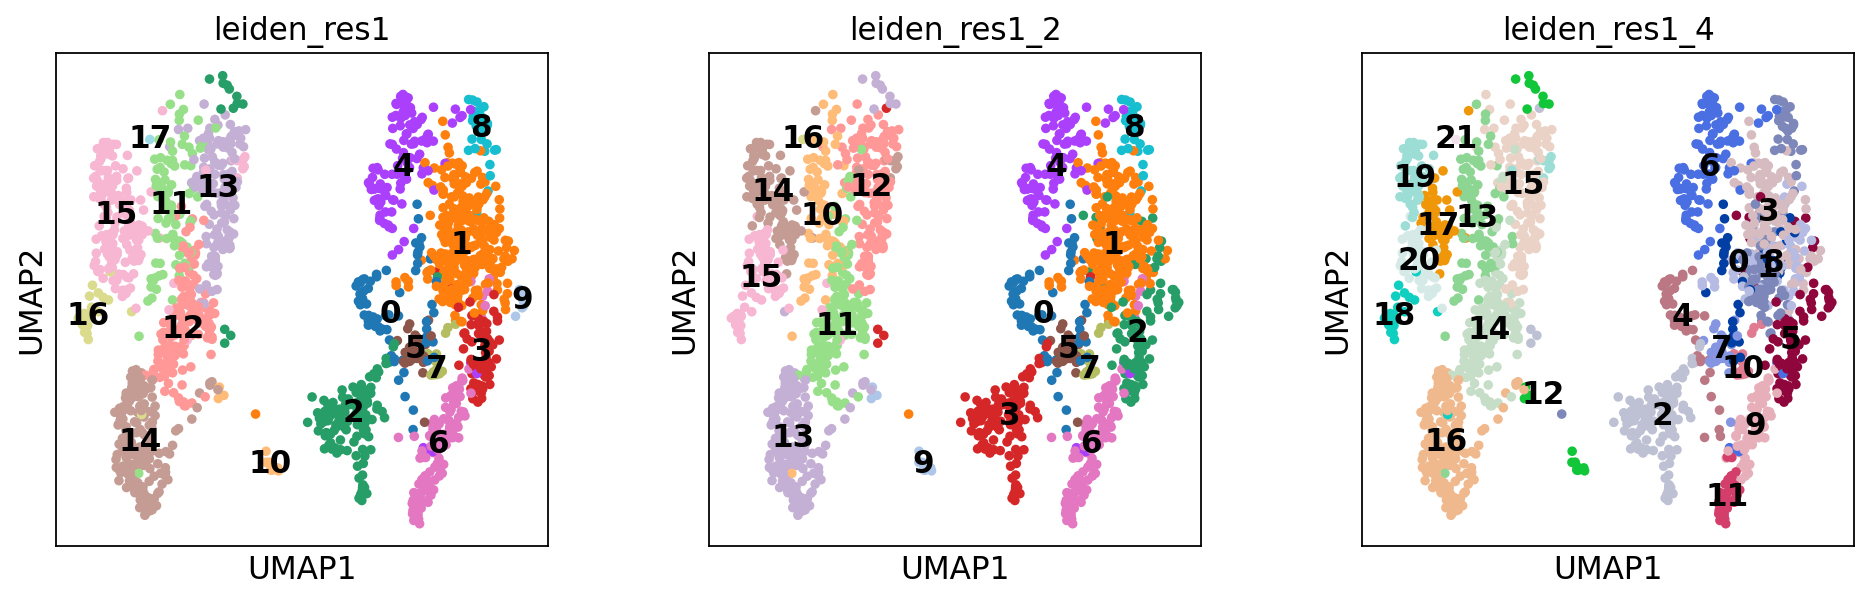

Infected tissue clustering completed
Next step: Examine individual clusters for concentrated STAT6 signals


In [18]:
# Perform clustering on infected tissue subset to look for M(Kp)-enriched subpopulations
sc.tl.leiden(infected_cells, flavor="igraph", key_added="leiden_res1", resolution=1)
sc.tl.leiden(infected_cells, flavor="igraph", key_added="leiden_res1_2", resolution=1.2)
sc.tl.leiden(infected_cells, flavor="igraph", key_added="leiden_res1_4", resolution=1.4)

# Visualize clustering patterns in infected tissue
sc.pl.umap(
    infected_cells,
    color=["leiden_res1", "leiden_res1_2", "leiden_res1_4"],
    legend_loc="on data",
)

print("Infected tissue clustering completed")
print("Next step: Examine individual clusters for concentrated STAT6 signals")

### Full Dataset Clustering Reference

Compare infected tissue clustering with overall dataset structure for context.

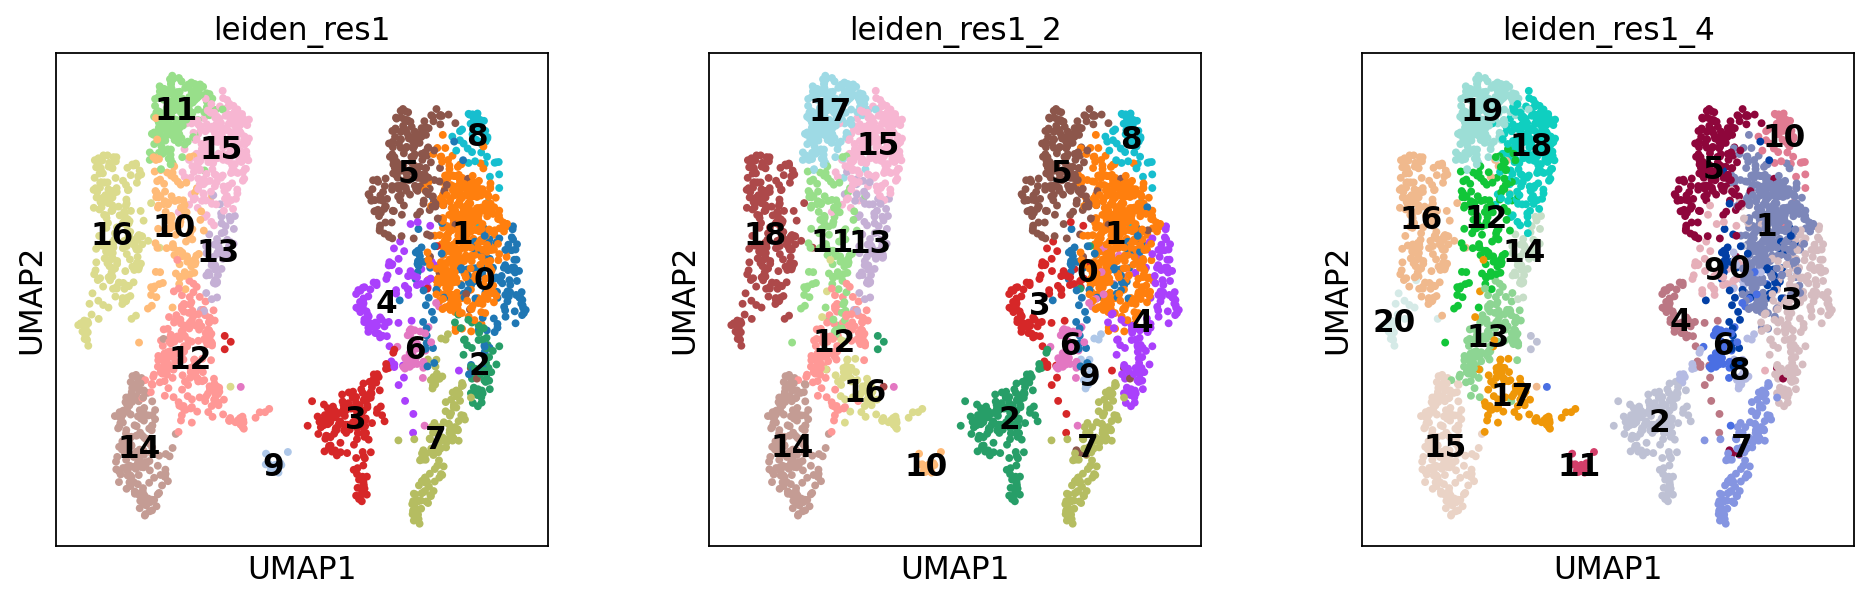

Full dataset clustering completed for reference


In [19]:
# Perform clustering on full dataset for comparison
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res1", resolution=1)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res1_2", resolution=1.2)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res1_4", resolution=1.4)

# Visualize full dataset clustering
sc.pl.umap(
    adata,
    color=["leiden_res1", "leiden_res1_2", "leiden_res1_4"],
    legend_loc="on data",
)

print("Full dataset clustering completed for reference")

## Final Assessment and Conclusions

### Pathway Enrichment Analysis Summary

**Classical Infection Validation**: ✅ **Successful**
- Strong interferon responses in IM cells
- Robust antimicrobial pathways in bacterial contact
- Clear immune activation signatures
- Expected cell type-specific differences

**M(Kp) STAT6 Signature**: ❌ **Not Detected**
- No STAT6 pathway enrichment in bacterial contact vs bystander comparisons
- No IL-4/IL-13 alternative activation signatures
- Missing the key mechanistic finding from the original study

### Biological Significance of Current Findings

Despite the absence of STAT6 signals, the analysis reveals important macrophage biology:

1. **Nutritional Immunity**: Iron sequestration responses (Fth1, Ftl1)
2. **Inflammatory Recruitment**: Chemokine production (Cxcl2, Cxcl3)  
3. **Tissue Protection**: Antimicrobial peptide responses (Slpi)
4. **Cell Type Specialization**: Distinct AM vs IM infection responses

### Future Directions

1. **Temporal Analysis**: Examine earlier/later timepoints for transient M(Kp) states
2. **Single-Cell Resolution**: Investigate if STAT6+ cells exist as rare subpopulations
3. **Alternative Markers**: Search for other M(Kp) signature components beyond STAT6
4. **Functional Validation**: Test capsule polysaccharide recognition pathways

### Conclusion

While we did not replicate the original study's STAT6-mediated M(Kp) signature, our analysis validates a robust infection model with clear biological responses to bacterial contact. The results suggest either temporal, methodological, or analytical differences that merit further investigation to fully characterize the M(Kp) polarization state.